In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
# from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import time



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers

In [12]:
X_train=np.load('/content/drive/MyDrive/deep_learning_project/X_train.npy')
X_test=np.load('/content/drive/MyDrive/deep_learning_project/X_test.npy')
y_train=np.load('/content/drive/MyDrive/deep_learning_project/y_train.npy')
y_test=np.load('/content/drive/MyDrive/deep_learning_project/y_test.npy')

In [ ]:
## Defining the input

from keras.layers import Input
resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50


#Get the RESNET weights and layers

model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_resnet50_conv.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#Use the generated model 
from keras.models import Model


output_resnet50_conv = model_resnet50_conv(resnet50_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_resnet50_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)


resnet50_pretrained = Model(resnet50_input, x)
# for layer in resnet50_pretrained.layers[:2]:
#     layer.trainable=False
# for layer in resnet50_pretrained.layers[2:]:
#     layer.trainable=True


resnet50_pretrained.summary()

# Compile CNN model
adam = keras.optimizers.Adam(lr=0.0001)
# sgd = optimizers.SGD(lr = 0.001)
resnet50_pretrained.compile(loss='categorical_crossentropy',optimizer = adam,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1003530   
Total params: 24,591,242
Trainable params: 24,538,122
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('resnet_weights_aug_alltrained_adam.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
resnet50_model = resnet50_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper,time_callback],
                                                            epochs = 80, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/80
269/269 [==============================] - 228s 761ms/step - loss: 2.6284 - accuracy: 0.3582 - val_loss: 1.7567 - val_accuracy: 0.7408

Epoch 00001: val_loss improved from inf to 1.75672, saving model to resnet_weights_aug_alltrained_adam.hdf5
Epoch 2/80
269/269 [==============================] - 200s 742ms/step - loss: 0.7251 - accuracy: 0.7670 - val_loss: 1.2067 - val_accuracy: 0.7499

Epoch 00002: val_loss improved from 1.75672 to 1.20668, saving model to resnet_weights_aug_alltrained_adam.hdf5
Epoch 3/80
269/269 [==============================] - 200s 741ms/step - loss: 0.5458 - accuracy: 0.8130 - val_loss: 1.6396 - val_accuracy: 0.7475

Epoch 00003: val_loss did not improve from 1.20668
Epoch 4/80
269/269 [==============================] - 200s 741ms/step - loss: 0.4596 - accuracy: 0.8513 - val_loss: 0.7200 - val_accuracy: 0.8250

Epoch 00004: val_loss improved from 1.20668 to 0.72002, saving model to resnet_weights_aug_alltrained_adam.hdf5
Epoch 5/80
269/269 [=========

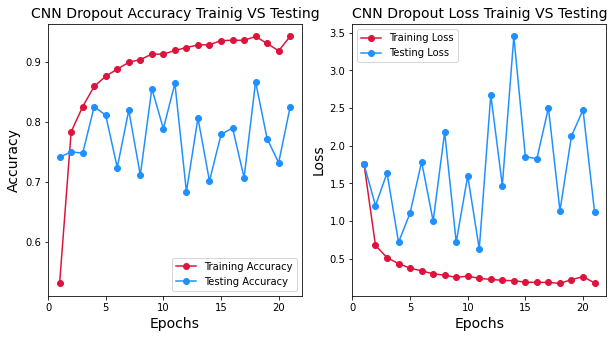

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(resnet50_pretrained.history.history['accuracy']) + 1), resnet50_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(resnet50_pretrained.history.history['val_accuracy']) + 1), resnet50_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['loss']) + 1), resnet50_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['val_loss']) + 1), resnet50_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

# sgd

In [13]:
## Defining the input

from keras.layers import Input
resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50


#Get the RESNET weights and layers

model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_resnet50_conv.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
# from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import math


import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import LearningRateScheduler#Use the generated model 



from keras.models import Model
import time
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()


output_resnet50_conv = model_resnet50_conv(resnet50_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_resnet50_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)


resnet50_pretrained = Model(resnet50_input, x)
# for layer in resnet50_pretrained.layers[:2]:
#     layer.trainable=False
# for layer in resnet50_pretrained.layers[2:]:
#     layer.trainable=True


resnet50_pretrained.summary()

# Compile CNN model
# adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)



def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
        math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

sgd = optimizers.SGD(lr = 0.0001)


resnet50_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1003530   
Total params: 24,591,242
Trainable params: 24,538,122
Non-trainable params: 53,120
_________________________________________________________________


In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('resnet_weights_aug_alltrained_sgd2_setval.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
resnet50_model = resnet50_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper,lrate,time_callback],
                                                            epochs = 80, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/80
269/269 [==============================] - 225s 757ms/step - loss: 3.1999 - accuracy: 0.2522 - val_loss: 1.4469 - val_accuracy: 0.6565

Epoch 00001: val_loss improved from inf to 1.44690, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
Epoch 2/80
269/269 [==============================] - 203s 751ms/step - loss: 1.4511 - accuracy: 0.5864 - val_loss: 1.3262 - val_accuracy: 0.7267

Epoch 00002: val_loss improved from 1.44690 to 1.32625, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
Epoch 3/80
269/269 [==============================] - 203s 753ms/step - loss: 1.0414 - accuracy: 0.6955 - val_loss: 0.9849 - val_accuracy: 0.7816

Epoch 00003: val_loss improved from 1.32625 to 0.98490, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
Epoch 4/80
269/269 [==============================] - 204s 754ms/step - loss: 0.8496 - accuracy: 0.7392 - val_loss: 0.8769 - val_accuracy: 0.8194

Epoch 00004: val_loss improved from 0.98490 to 0.87689, sav

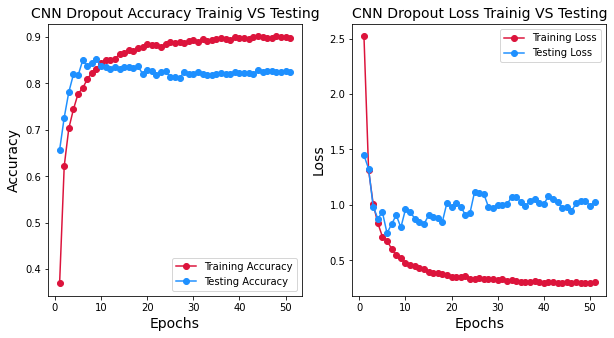

In [16]:

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(resnet50_pretrained.history.history['accuracy']) + 1), resnet50_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(resnet50_pretrained.history.history['val_accuracy']) + 1), resnet50_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['loss']) + 1), resnet50_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['val_loss']) + 1), resnet50_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [17]:
res_50_sgd_with_augment = pd.DataFrame(resnet50_model.history)
res_50_sgd_with_augment['time'] = time_callback.times
res_50_sgd_with_augment.to_csv('res_50_sgd_with_augment.csv')